+---------+-----+
|age_group|count|
+---------+-----+
|    20-25| 8005|
|    25-35|13163|
|    35-50|19505|
|      50+|11488|
|      <20|19349|
+---------+-----+



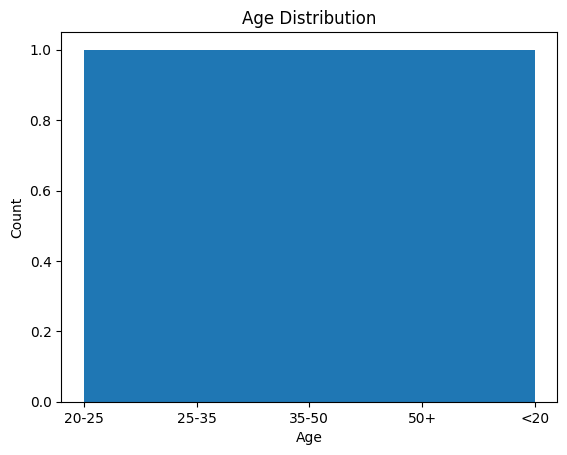

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark import SparkConf
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt

# conf = SparkConf().setAppName("MyFirst").setMaster("Local[*]")

# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load the database tables into Spark DataFrames
df_customers = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:sqlserver://localhost:1433;databaseName=NewSampleDW;") \
    .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .option("dbtable", "dbo.DimCustomers") \
    .option("user", "python_insert") \
    .option("password", "password") \
    .load()

df_dates = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:sqlserver://localhost:1433;databaseName=NewSampleDW;") \
    .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .option("dbtable", "dbo.DimDate") \
    .option("user", "python_insert") \
    .option("password", "password") \
    .load()

df_age = df_customers.join(df_dates, df_customers["BirthDateKey"] == df_dates["DateKey"], "inner")

# Calculate the age of each customer based on their birthdate
df_age = df_age.withColumn("age", (2023 - df_dates["Year"]))

# Define age groups using `when` function
df_age = df_age.withColumn("age_group", 
    when(col("age") < 20, "<20")
    .when((col("age") >= 20) & (col("age") <= 25), "20-25")
    .when((col("age") > 25) & (col("age") <= 35), "25-35")
    .when((col("age") > 35) & (col("age") <= 50), "35-50")
    .otherwise("50+")
)

# THEN CREATE A GRAPH TO SHOW MOST SOLD PRODUCT BY AGE

# Group customers by age group and count the number of customers in each group
result = df_age.groupBy("age_group").count().orderBy("age_group")
result.show()

# Show the result
pandas_df = result.toPandas()

plt.hist(pandas_df["age_group"], bins=5)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()